###### Università degli Studi di Milano, Data Science and Economics Master Degree

# More on Linear Function Approximation
## Implementation and limits

### Alfio Ferrara

## Monte Carlo and TD(0)
Let's start from a simple example, where we show a LFA agent interacting with a tabular environment addressed like a continuous one and with a real continuous environment.

Note that, for all the examples, we need a custom function that extracts features from the state.

In [1]:
import gymnasium as gym 
from gymbase import vfa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Example of Cliff Walking
Adapted from Example 6.6 (page 132) from [Reinforcement Learning: An Introduction](https://gymnasium.farama.org/environments/toy_text/cliff_walking/#cliffwalk_ref) by Sutton and Barto.

The game starts with the player at location [3, 0] of the 4x12 grid world with the goal located at [3, 11]. If the player reaches the goal the episode ends.

A cliff runs along [3, 1..10]. If the player moves to a cliff location it returns to the start location.

The player makes moves until they reach the goal.

### States
There are 3 x 12 + 1 possible states. The player cannot be at the cliff, nor at the goal as the latter results in the end of the episode. What remains are all the positions of the first 3 rows plus the bottom-left cell.

The observation is a value representing the player’s current position as current_row * ncols + current_col (where both the row and col start at 0).

For example, the starting position can be calculated as follows: 3 * 12 + 0 = 36.

The observation is returned as an int().

### Actions
0. Move up
1. Move right
2. Move down
3. Move left

### Rewards
Each time step incurs **-1 reward**, unless the player **stepped into the cliff**, which incurs -100 reward.

See the [Gym env page](https://gymnasium.farama.org/environments/toy_text/cliff_walking/) for further details.

In [2]:
import time
from IPython.display import clear_output

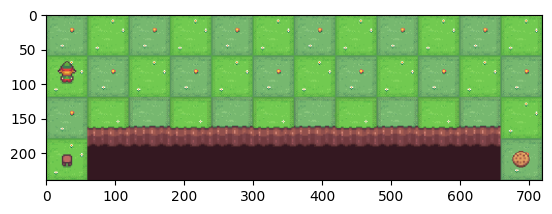

In [3]:
env = gym.make('CliffWalking-v0', render_mode='rgb_array', is_slippery=True)
state, info = env.reset()

def policy(state: int):
    return env.action_space.sample()

end_episode = False 
max_count = 100
while not end_episode:
    if max_count < 0:
        break 
    action = policy(state)
    s_prime, reward, terminated, truncated, info = env.step(action)
    end_episode = terminated or truncated
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
    time.sleep(.1)
    state = s_prime
    max_count -= 1
    
env.close()

### Feature extraction

In [4]:
def cliff_walk_12(state: int):
    # current_row * ncols + current_col = state
    row = state // 12
    col = state % 12
    bias = 1
    return np.array([col, row, bias])

### Monte Carlo

In [5]:
episodes = 500
env = gym.make('CliffWalking-v0', is_slippery=True)
m_env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=100)

num_features = 3
mc_agent = vfa.LinearApproximator(feature_extractor=cliff_walk_12, num_features=num_features)

print("Training")
vfa.monte_carlo(env=m_env, approximator=mc_agent, episodes=episodes)


Training


100%|██████████| 500/500 [00:43<00:00, 11.44it/s]


In [6]:
def conv(a, win=1000):
    return np.convolve(a, np.ones(win), mode='same') / win

cwin = 4_000

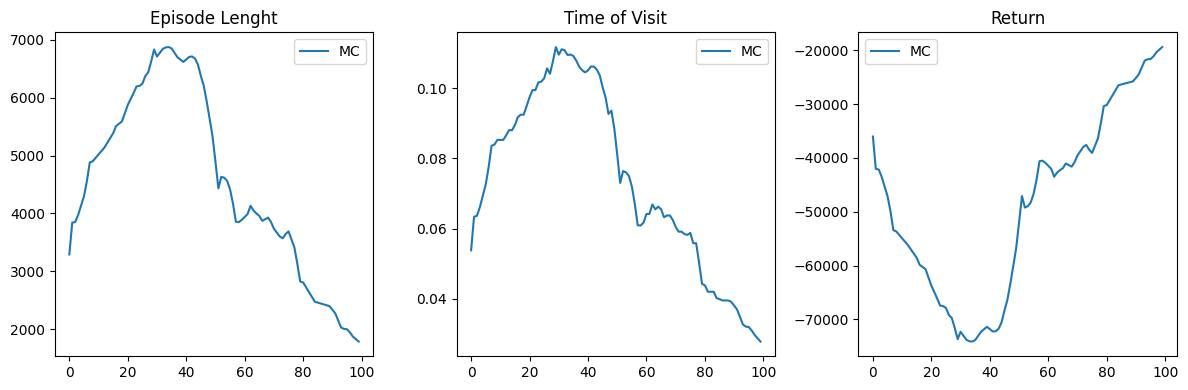

In [7]:
mlen, mtime, mret = conv(m_env.length_queue, win=50), conv(m_env.time_queue, win=50), conv(m_env.return_queue, win=50)

fig, ax = plt.subplots(figsize=(12, 4), ncols=3, nrows=1)
sns.lineplot(x=range(len(mlen)), y=mlen, ax=ax[0], label="MC")
sns.lineplot(x=range(len(mtime)), y=mtime, ax=ax[1], label="MC")
sns.lineplot(x=range(len(mret)), y=mret, ax=ax[2], label="MC")
ax[0].set_title("Episode Lenght")
ax[1].set_title("Time of Visit")
ax[2].set_title("Return")
plt.tight_layout()
plt.show()

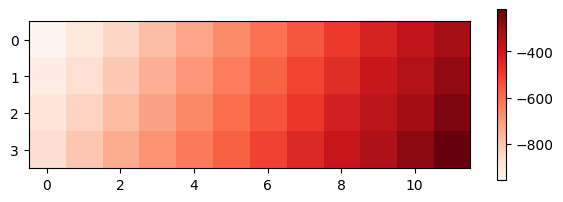

In [8]:
mcv = mc_agent.weights
grid = np.zeros((4, 12))
for s in range(env.observation_space.n):
    grid[s // 12, s % 12] = mc_agent.predict(s)
fig, ax = plt.subplots(figsize=(6, 6))
plot = ax.imshow(grid, cmap='Reds')
fig.colorbar(plot, ax=ax, location='right', anchor=(0, 0.5), shrink=0.3)
plt.tight_layout()
plt.show()

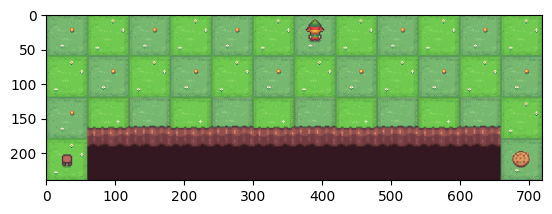

In [9]:
env = gym.make('CliffWalking-v0', render_mode='rgb_array', is_slippery=True)
state, info = env.reset()

def policy(state: int):
    return np.argmax([mc_agent.predict(state) for _ in range(env.action_space.n)])

end_episode = False 
max_count = 100
while not end_episode:
    if max_count < 0:
        break 
    action = policy(state)
    s_prime, reward, terminated, truncated, info = env.step(action)
    end_episode = terminated or truncated
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
    time.sleep(.1)
    state = s_prime
    max_count -= 1
    
env.close()

### TD(0)

In [10]:
episodes = 300
env = gym.make('CliffWalking-v0', is_slippery=True)
t_env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=100)

num_features = 3
td_agent = vfa.LinearApproximator(feature_extractor=cliff_walk_12, num_features=num_features)

print("Training")
vfa.td_0(env=t_env, approximator=td_agent, episodes=episodes)

Training


100%|██████████| 300/300 [00:25<00:00, 11.55it/s]


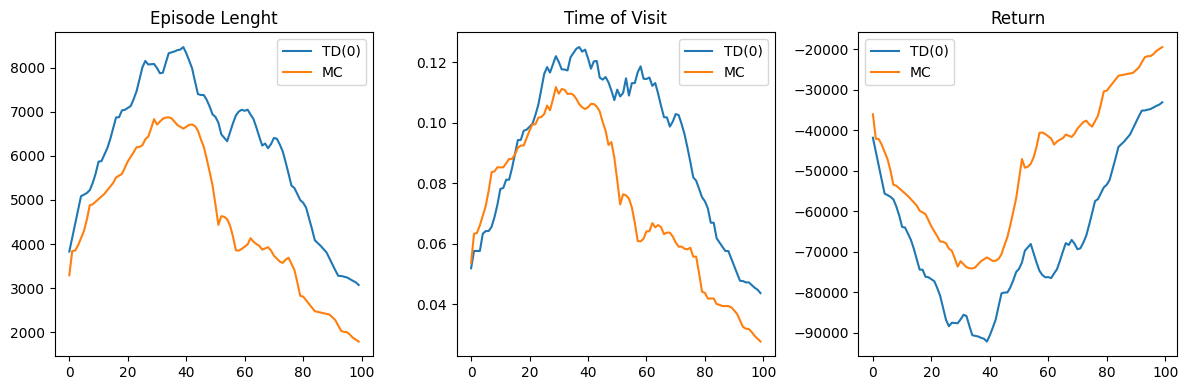

In [11]:
tlen, ttime, tret = conv(t_env.length_queue, win=50), conv(t_env.time_queue, win=50), conv(t_env.return_queue, win=50)

fig, ax = plt.subplots(figsize=(12, 4), ncols=3, nrows=1)
sns.lineplot(x=range(len(tlen)), y=tlen, ax=ax[0], label="TD(0)")
sns.lineplot(x=range(len(mlen)), y=mlen, ax=ax[0], label="MC")
sns.lineplot(x=range(len(ttime)), y=ttime, ax=ax[1], label="TD(0)")
sns.lineplot(x=range(len(mtime)), y=mtime, ax=ax[1], label="MC")
sns.lineplot(x=range(len(tret)), y=tret, ax=ax[2], label="TD(0)")
sns.lineplot(x=range(len(mret)), y=mret, ax=ax[2], label="MC")
ax[0].set_title("Episode Lenght")
ax[1].set_title("Time of Visit")
ax[2].set_title("Return")
plt.tight_layout()
plt.show()

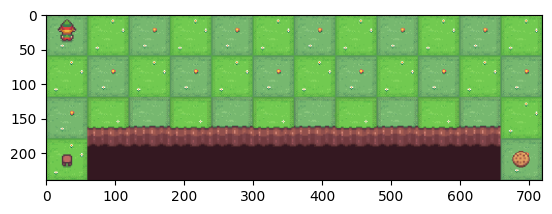

In [12]:
env = gym.make('CliffWalking-v0', render_mode='rgb_array', is_slippery=True)
state, info = env.reset()

def policy(state: int):
    return np.argmax([td_agent.predict(state) for _ in range(env.action_space.n)])

end_episode = False 
max_count = 100
while not end_episode:
    if max_count < 0:
        break 
    action = policy(state)
    s_prime, reward, terminated, truncated, info = env.step(action)
    end_episode = terminated or truncated
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
    time.sleep(.1)
    state = s_prime
    max_count -= 1
    
env.close()

# Control problems

## Continuous Environment
Let's work now with a continuous environment

### Lunar Lander with Discrete Actions
See [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) for the environment description

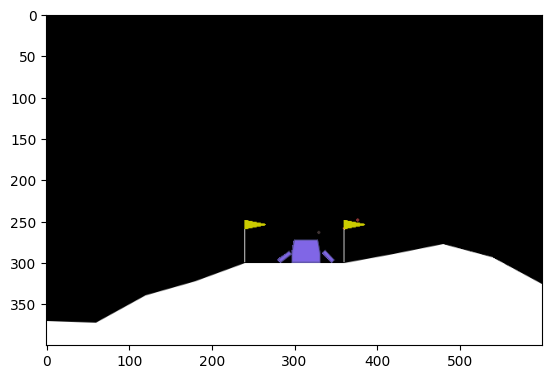

In [13]:
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode='rgb_array')

def policy(state: int):
    return env.action_space.sample()

for episode in range(2):
    states = []
    state, info = env.reset()
    end_episode = False 
    while not end_episode:
        action = policy(state)
        s_prime, reward, terminated, truncated, info = env.step(action)
        end_episode = terminated or truncated
        clear_output(wait=True)
        plt.imshow(env.render())
        plt.show()
        state = s_prime
        states.append(state)
    
# Collect rewards with no rendering
random_rewards = []
for episode in range(100):
    states = []
    state, info = env.reset()
    end_episode = False 
    episodic_reward = 0
    while not end_episode:
        action = policy(state)
        s_prime, reward, terminated, truncated, info = env.step(action)
        episodic_reward += reward
        end_episode = terminated or truncated
        clear_output(wait=True)
        state = s_prime
        states.append(state)
    random_rewards.append(episodic_reward)

env.close()

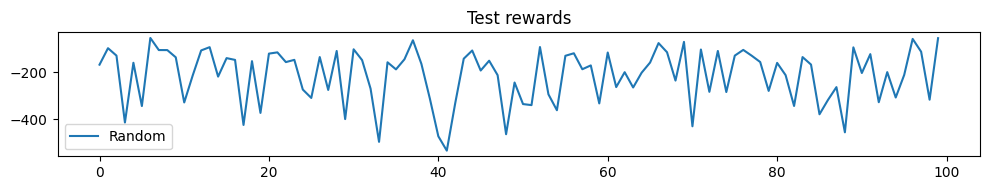

In [14]:
fig, ax = plt.subplots(figsize=(10, 2), ncols=1, nrows=1)
sns.lineplot(x=range(100), y=random_rewards, ax=ax, label="Random")
ax.set_title("Test rewards")
plt.tight_layout()
plt.show()

In [15]:
def lunar(state):
    # We just append a bias term
    return np.append(state, 1.0)

In [16]:
episodes = 10_000
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode='rgb_array')
t_env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=100)
q_env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=100)
num_actions = t_env.action_space.n
num_features = 9

sarsa_agent = vfa.LinearQApproximator(feature_extractor=lunar, num_features=num_features, num_actions=num_actions, alpha=0.35)
q_agent = vfa.LinearQApproximator(feature_extractor=lunar, num_features=num_features, num_actions=num_actions, alpha=0.35)

print("Training SARSA")
history = vfa.sarsa(env=t_env, approximator=sarsa_agent, episodes=episodes, keep_history=True, epsilon_decay=0.95)

print("Training Q-Learning")
history = vfa.q_learning(env=q_env, approximator=q_agent, episodes=episodes, keep_history=True, epsilon_decay=0.95)

Training SARSA


  1%|          | 92/10000 [00:00<01:00, 163.69it/s]/Users/Flint/Scriptorium/didattica/reinforcement-learning/rlcoding/2024-25/gymbase/vfa.py:89: RuntimeWarning: invalid value encountered in multiply
  self.weights[action] += self.alpha * error * features
100%|██████████| 10000/10000 [00:23<00:00, 421.47it/s]


Training Q-Learning


100%|██████████| 10000/10000 [00:32<00:00, 307.47it/s]


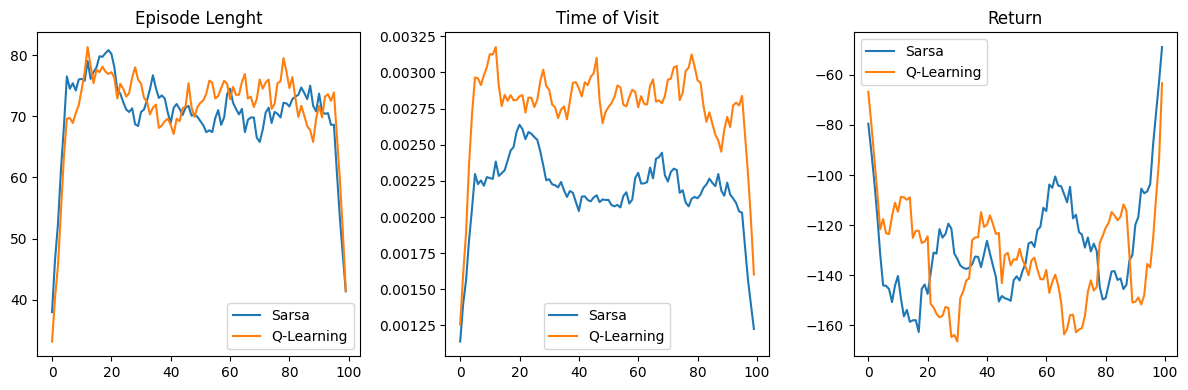

In [17]:
win = 10
tlen, ttime, tret = conv(t_env.length_queue, win=win), conv(t_env.time_queue, win=win), conv(t_env.return_queue, win=win)
qlen, qtime, qret = conv(q_env.length_queue, win=win), conv(q_env.time_queue, win=win), conv(q_env.return_queue, win=win)

fig, ax = plt.subplots(figsize=(12, 4), ncols=3, nrows=1)
sns.lineplot(x=range(len(tlen)), y=tlen, ax=ax[0], label="Sarsa")
sns.lineplot(x=range(len(ttime)), y=ttime, ax=ax[1], label="Sarsa")
sns.lineplot(x=range(len(tret)), y=tret, ax=ax[2], label="Sarsa")
sns.lineplot(x=range(len(qlen)), y=qlen, ax=ax[0], label="Q-Learning")
sns.lineplot(x=range(len(qtime)), y=qtime, ax=ax[1], label="Q-Learning")
sns.lineplot(x=range(len(qret)), y=qret, ax=ax[2], label="Q-Learning")
ax[0].set_title("Episode Lenght")
ax[1].set_title("Time of Visit")
ax[2].set_title("Return")
plt.tight_layout()
plt.show()

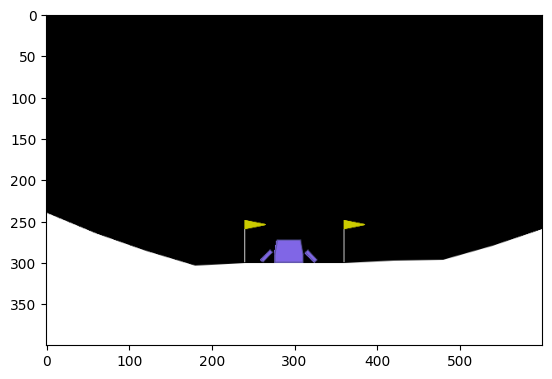

In [18]:
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode='rgb_array')

def policy(state: int):
    return np.argmax([q_agent.predict(state, action) for action in range(env.action_space.n)])

for episode in range(4):
    end_episode = False 
    state, info = env.reset()

    while not end_episode:
        action = policy(state)
        s_prime, reward, terminated, truncated, info = env.step(action)
        end_episode = terminated or truncated
        clear_output(wait=True)
        plt.imshow(env.render())
        plt.show()
        state = s_prime
    
env.close()

In [19]:
def test(env, agent, episodes=100):
    # Collect rewards with no rendering
    total_rewards = []
    for episode in range(episodes):
        states = []
        state, info = env.reset()
        end_episode = False 
        episodic_reward = 0
        while not end_episode:
            action = np.argmax([agent.predict(state, action) for action in range(env.action_space.n)])
            s_prime, reward, terminated, truncated, info = env.step(action)
            episodic_reward += reward
            end_episode = terminated or truncated
            clear_output(wait=True)
            state = s_prime
            states.append(state)
        total_rewards.append(episodic_reward)
    return total_rewards

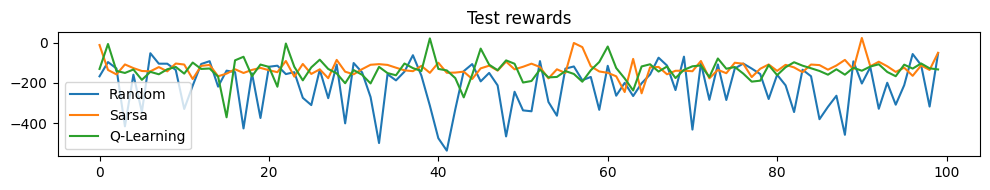

In [20]:
sarsa_rewards = test(env, sarsa_agent, episodes=100)
q_rewards = test(env, q_agent, episodes=100)

fig, ax = plt.subplots(figsize=(10, 2), ncols=1, nrows=1)
sns.lineplot(x=range(100), y=random_rewards, ax=ax, label="Random")
sns.lineplot(x=range(100), y=sarsa_rewards, ax=ax, label="Sarsa")
sns.lineplot(x=range(100), y=q_rewards, ax=ax, label="Q-Learning")
ax.set_title("Test rewards")
plt.tight_layout()
plt.show()

## A difficult problem
### Mountain Car with Discrete Actions
See [Mountain Car](https://gymnasium.farama.org/environments/classic_control/mountain_car/) for the environment description

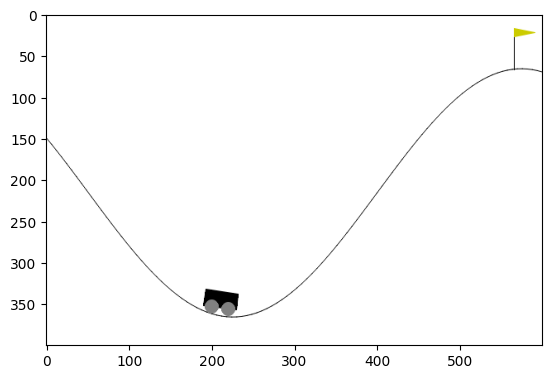

In [22]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
state, info = env.reset()

def policy(state: int):
    return env.action_space.sample()

states = []

end_episode = False 
while not end_episode:
    action = policy(state)
    s_prime, reward, terminated, truncated, info = env.step(action)
    end_episode = terminated or truncated
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
    state = s_prime
    states.append(state)
    
env.close()

In [23]:
S = np.array(states) 
S[:6]

array([[-4.3692634e-01,  3.5986552e-04],
       [-4.3620923e-01,  7.1712240e-04],
       [-4.3614003e-01,  6.9183123e-05],
       [-4.3671930e-01, -5.7925726e-04],
       [-4.3894279e-01, -2.2235010e-03],
       [-4.4179443e-01, -2.8516173e-03]], dtype=float32)

We get features as they are provided by the environment, but we include a **bias** term to improve stability in learning. Moreover, we normalize the features

In [24]:
def car_features(state):
    position, velocity = state
    return np.array([(position + 1.2) / 1.8, velocity / 0.07, 1.0], dtype=np.float32) 

def conv(a, win=1000):
    return np.convolve(a, np.ones(win), mode='same') / win

cwin = 4_000

In [26]:
car_features(states[0])

array([0.42392984, 0.00514094, 1.        ], dtype=float32)

### Sarsa
**Note** that we increase the default duration of episodes due to the reward set to the end

In [27]:
episodes = 3000
env = gym.make("MountainCar-v0", render_mode="rgb_array")
env._max_episode_steps = 200
t_env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=100)
num_actions = t_env.action_space.n

num_features = 3
sarsa_agent = vfa.LinearQApproximator(feature_extractor=car_features, num_features=num_features, num_actions=num_actions, alpha=0.3)

print("Training SARSA")
history = vfa.sarsa(env=t_env, approximator=sarsa_agent, episodes=episodes, keep_history=True, epsilon_decay=0.98)

Training SARSA


100%|██████████| 3000/3000 [00:09<00:00, 328.10it/s]


### Q-Learning

In [33]:
episodes = 3000
env = gym.make("MountainCar-v0", render_mode="rgb_array")
env._max_episode_steps = 400
q_env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=100)
num_actions = t_env.action_space.n

num_features = 3
q_agent = vfa.LinearQApproximator(feature_extractor=car_features, num_features=num_features, num_actions=num_actions, alpha=0.3)

print("Training Q-Learning")
history = vfa.q_learning(env=q_env, approximator=q_agent, episodes=episodes, keep_history=True, epsilon_decay=0.99998)

Training Q-Learning


100%|██████████| 3000/3000 [00:20<00:00, 147.38it/s]


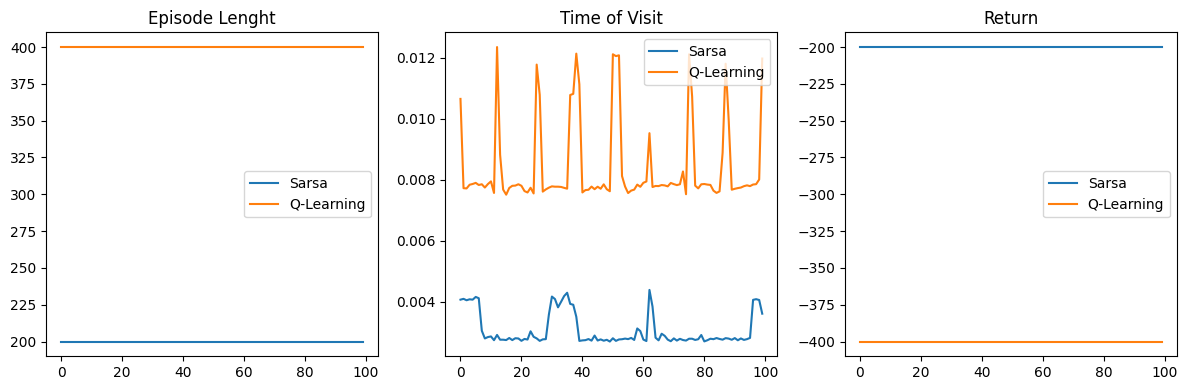

In [32]:
tlen, ttime, tret = conv(t_env.length_queue, win=1), conv(t_env.time_queue, win=1), conv(t_env.return_queue, win=1)
qlen, qtime, qret = conv(q_env.length_queue, win=1), conv(q_env.time_queue, win=1), conv(q_env.return_queue, win=1)

fig, ax = plt.subplots(figsize=(12, 4), ncols=3, nrows=1)
sns.lineplot(x=range(len(tlen)), y=tlen, ax=ax[0], label="Sarsa")
sns.lineplot(x=range(len(ttime)), y=ttime, ax=ax[1], label="Sarsa")
sns.lineplot(x=range(len(tret)), y=tret, ax=ax[2], label="Sarsa")
sns.lineplot(x=range(len(qlen)), y=qlen, ax=ax[0], label="Q-Learning")
sns.lineplot(x=range(len(qtime)), y=qtime, ax=ax[1], label="Q-Learning")
sns.lineplot(x=range(len(qret)), y=qret, ax=ax[2], label="Q-Learning")
ax[0].set_title("Episode Lenght")
ax[1].set_title("Time of Visit")
ax[2].set_title("Return")
plt.tight_layout()
plt.show()

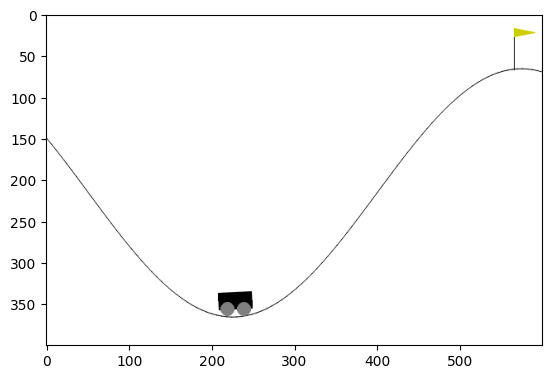

In [30]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')
state, info = env.reset()

def policy(state: int):
    return np.argmax([sarsa_agent.predict(state, action) for action in range(env.action_space.n)])

end_episode = False 
while not end_episode:
    action = policy(state)
    s_prime, reward, terminated, truncated, info = env.step(action)
    end_episode = terminated or truncated
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
    state = s_prime
    
env.close()

### Discussion about the environment: why is it so difficult to learn?

Keep in mind that `MountainCar` has a stable reward of `-1` always. So, in order to reach a non negative reward, we need to reach the flag by chance!
Let's provide a modified reward which is proportional to the flag distance.

In order to do this, we can use a `Gym wrapper`.

In [41]:
class MountainCarRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super(MountainCarRewardWrapper, self).__init__(env)
        self.goal_position = 0.5  # Flag position
        self.min_position = -1.2  # Minimum position in the environment

    def step(self, action):
        next_state, _, done, truncated, info = self.env.step(action)
        position, velocity = next_state
        reward = np.abs(velocity)
        return next_state, reward, done, truncated, info

**Train with the new reward function**

In [47]:
episodes = 6000
env = gym.make("MountainCar-v0", render_mode="rgb_array")
env._max_episode_steps = 200
#env = MountainCarRewardWrapper(env)
t_env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=100)
q_env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=100)
num_actions = t_env.action_space.n

sarsa_agent = vfa.LinearQApproximator(feature_extractor=car_features, num_features=num_features, num_actions=num_actions, alpha=0.3)
q_agent = vfa.LinearQApproximator(feature_extractor=car_features, num_features=num_features, num_actions=num_actions, alpha=0.3)

print("Training SARSA")
history = vfa.sarsa(env=t_env, approximator=sarsa_agent, episodes=episodes, keep_history=True, epsilon_decay=0.98)

print("Training Q-Learning")
history = vfa.q_learning(env=q_env, approximator=q_agent, episodes=episodes, keep_history=True, epsilon_decay=0.98)

Training SARSA


100%|██████████| 6000/6000 [00:18<00:00, 326.07it/s]


Training Q-Learning


100%|██████████| 6000/6000 [00:25<00:00, 235.40it/s]


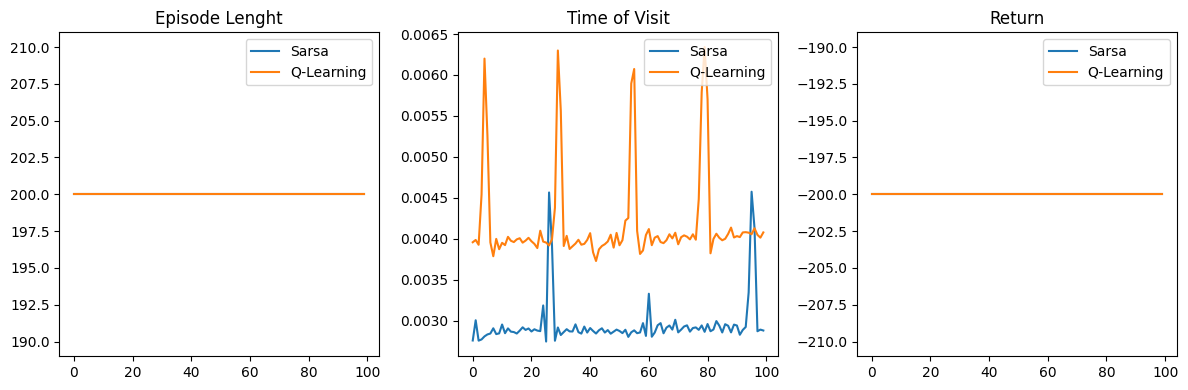

In [48]:
tlen, ttime, tret = conv(t_env.length_queue, win=1), conv(t_env.time_queue, win=1), conv(t_env.return_queue, win=1)
qlen, qtime, qret = conv(q_env.length_queue, win=1), conv(q_env.time_queue, win=1), conv(q_env.return_queue, win=1)

fig, ax = plt.subplots(figsize=(12, 4), ncols=3, nrows=1)
sns.lineplot(x=range(len(tlen)), y=tlen, ax=ax[0], label="Sarsa")
sns.lineplot(x=range(len(ttime)), y=ttime, ax=ax[1], label="Sarsa")
sns.lineplot(x=range(len(tret)), y=tret, ax=ax[2], label="Sarsa")
sns.lineplot(x=range(len(qlen)), y=qlen, ax=ax[0], label="Q-Learning")
sns.lineplot(x=range(len(qtime)), y=qtime, ax=ax[1], label="Q-Learning")
sns.lineplot(x=range(len(qret)), y=qret, ax=ax[2], label="Q-Learning")
ax[0].set_title("Episode Lenght")
ax[1].set_title("Time of Visit")
ax[2].set_title("Return")
plt.tight_layout()
plt.show()

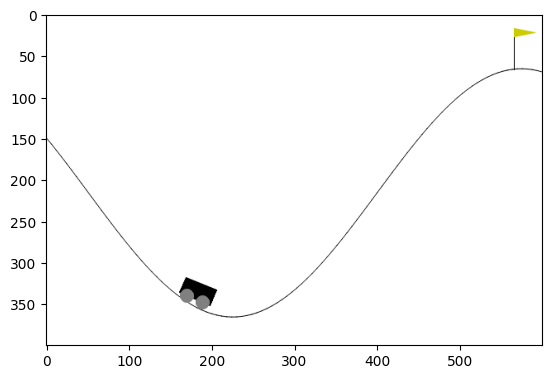

In [49]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')
state, info = env.reset()

def policy(state: int):
    return np.argmax([sarsa_agent.predict(state, action) for action in range(env.action_space.n)])

end_episode = False 
while not end_episode:
    action = policy(state)
    s_prime, reward, terminated, truncated, info = env.step(action)
    end_episode = terminated or truncated
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
    state = s_prime
    
env.close()

### Use a linear solution for a non linear problem.
The other big issue here is that the function that we are looking for is not linear, but we are using a linear transformation of the features, which are also linear.

**Momentum Dynamics Are Nonlinear**

The car must move left first to build momentum before reaching the goal.
A linear function cannot capture this because the Q-value function is highly nonlinear.

The true Q-function varies sharply between positions, because actions have different effects depending on momentum.
Linear models cannot capture these sudden changes in optimal actions.


#### Let's visualize the dynamics of Q-values
In Mountain car:
- position in $[-1.2, 0.6]$
- velocity in $[-0.07, 0.07]$

In [50]:
def history_time(parameters, features):
    pos_ticks = list(np.arange(start=-1.2, stop=0.61, step=.1))
    vel_ticks = list(np.arange(start=-0.07, stop=0.071, step=.01))
    q_table = np.zeros((len(vel_ticks), len(pos_ticks)))
    for col, pos in enumerate(pos_ticks):
        for row, vel in enumerate(vel_ticks):
            x = features(np.array([pos, vel]))
            q_table[row, col] = np.max([np.dot(parameters[action], x) for action in range(parameters.shape[0])])
    return q_table

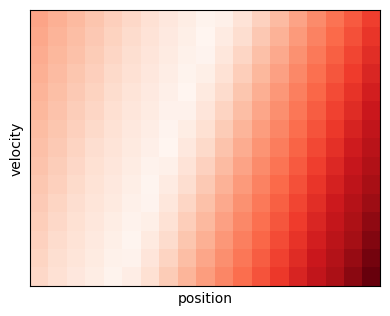

In [51]:
for i, h in enumerate(history):
    if i % 5 == 0:
        qt = history_time(h, car_features)
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(qt, cmap='Reds')
        ax.set_xlabel('position')
        ax.set_ylabel('velocity')
        ax.set_xticks([])
        ax.set_yticks([])
        plt.tight_layout()
        clear_output(wait=True)
        plt.show()

## First solution: use non linear tranformations of the state features

### Radial Basis Function (RBF) Feature Transformation
We are going to compute features as:

$$
\mathbf{x(s)} = \exp\left( - \frac{\mid\mid s - \mu_i \mid\mid^2}{2 \sigma^2} \right)
$$

where $\mu_i$ is the center of the point $i$ and $\sigma$ controls the spread. The is is to place multiple point values across the state space to capture different regions. Then, each RBF transformation will have a strong response when the state is close to its center and a weak response when far away.

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler

In [53]:
num_samples = 1000 
positions = np.linspace(-1.2, 0.6, int(np.sqrt(num_samples))) 
velocities = np.linspace(-0.07, 0.07, int(np.sqrt(num_samples)))  
state_samples_mu = np.array([[p, v] for p in positions for v in velocities])

scaler = StandardScaler()
scaler.fit(state_samples_mu)

rbf_feature_transformer = RBFSampler(gamma=1.0, n_components=50, random_state=42)
rbf_feature_transformer.fit(scaler.transform(state_samples_mu))

RBFSampler(n_components=50, random_state=42)

In [54]:
def car_features_rbf(state):
    state = np.array(state).reshape(1, -1)
    scaled_state = scaler.transform(state)
    return rbf_feature_transformer.transform(scaled_state)[0]

In [56]:
example = np.array([-0.4, 0.01])
features = car_features_rbf(state)
num_features = len(features)
print(features, len(features))

[-0.10882028  0.00751157  0.19773941  0.1571863   0.19762515 -0.12358241
 -0.04083853 -0.17017626 -0.18283748  0.15187468  0.19553595 -0.08807404
 -0.19483048 -0.16689377 -0.19275628  0.14744631  0.0158429  -0.19116822
  0.07649097 -0.19983575 -0.07817926 -0.02439311  0.13245029 -0.06152568
  0.17824357  0.03366489  0.1130518  -0.05491699 -0.09418428  0.03455662
 -0.19346156 -0.11936171 -0.13548031 -0.06559562  0.19605679  0.19827472
 -0.04579827 -0.19863389  0.00920879 -0.18605327 -0.18312498  0.1994406
 -0.19610691 -0.02859011  0.13634265 -0.04605716  0.01212544  0.02944733
  0.14990231 -0.16487986] 50


#### Let's use the new features in learning

In [57]:
episodes = 3000
env = gym.make("MountainCar-v0", render_mode="rgb_array")
env._max_episode_steps = 200
#env = MountainCarRewardWrapper(env)
t_env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=100)
q_env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=100)
num_actions = t_env.action_space.n

sarsa_agent = vfa.LinearQApproximator(feature_extractor=car_features_rbf, num_features=num_features, num_actions=num_actions, alpha=0.4)
q_agent = vfa.LinearQApproximator(feature_extractor=car_features_rbf, num_features=num_features, num_actions=num_actions, alpha=0.4)

print("Training SARSA")
history = vfa.sarsa(env=t_env, approximator=sarsa_agent, episodes=episodes, keep_history=True, epsilon_decay=0.98)

print("Training Q-Learning")
history = vfa.q_learning(env=q_env, approximator=q_agent, episodes=episodes, keep_history=True, epsilon_decay=0.98)

Training SARSA


100%|██████████| 3000/3000 [03:12<00:00, 15.60it/s]


Training Q-Learning


100%|██████████| 3000/3000 [06:23<00:00,  7.82it/s]


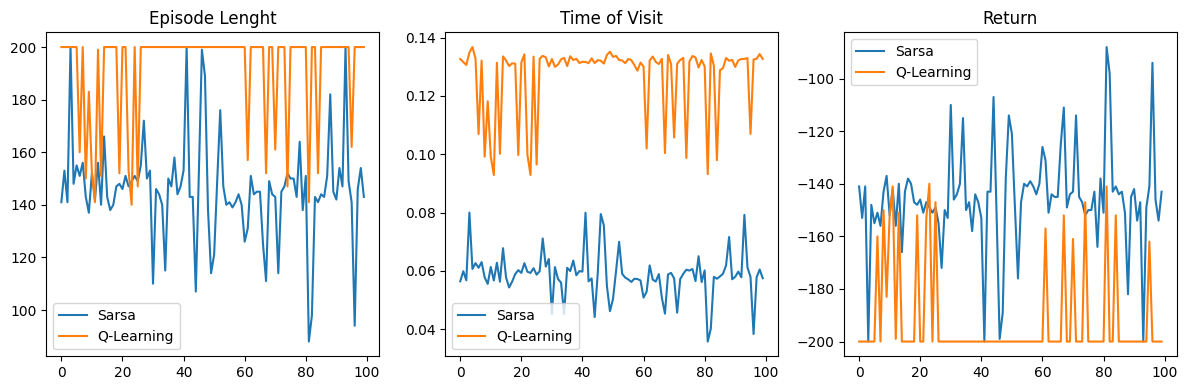

In [58]:
tlen, ttime, tret = conv(t_env.length_queue, win=1), conv(t_env.time_queue, win=1), conv(t_env.return_queue, win=1)
qlen, qtime, qret = conv(q_env.length_queue, win=1), conv(q_env.time_queue, win=1), conv(q_env.return_queue, win=1)

fig, ax = plt.subplots(figsize=(12, 4), ncols=3, nrows=1)
sns.lineplot(x=range(len(tlen)), y=tlen, ax=ax[0], label="Sarsa")
sns.lineplot(x=range(len(ttime)), y=ttime, ax=ax[1], label="Sarsa")
sns.lineplot(x=range(len(tret)), y=tret, ax=ax[2], label="Sarsa")
sns.lineplot(x=range(len(qlen)), y=qlen, ax=ax[0], label="Q-Learning")
sns.lineplot(x=range(len(qtime)), y=qtime, ax=ax[1], label="Q-Learning")
sns.lineplot(x=range(len(qret)), y=qret, ax=ax[2], label="Q-Learning")
ax[0].set_title("Episode Lenght")
ax[1].set_title("Time of Visit")
ax[2].set_title("Return")
plt.tight_layout()
plt.show()

#### Considerations
The new features still are not enough to solve the problem, but we can see how the state values now change.

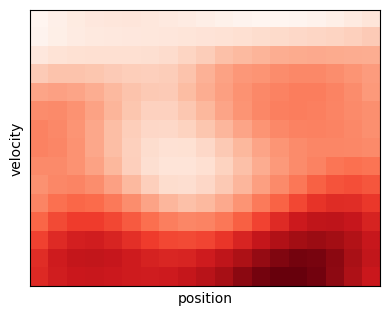

In [59]:
for i, h in enumerate(history):
    if i % 5 == 0:
        qt = history_time(h, car_features_rbf)
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(qt, cmap='Reds')
        ax.set_xlabel('position')
        ax.set_ylabel('velocity')
        ax.set_xticks([])
        ax.set_yticks([])
        plt.tight_layout()
        clear_output(wait=True)
        plt.show()

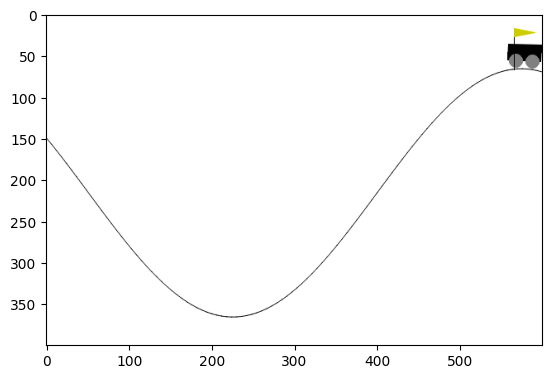

In [61]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')
state, info = env.reset()

def policy(state: int):
    return np.argmax([sarsa_agent.predict(state, action) for action in range(env.action_space.n)])

end_episode = False 
while not end_episode:
    action = policy(state)
    s_prime, reward, terminated, truncated, info = env.step(action)
    end_episode = terminated or truncated
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
    state = s_prime
    
env.close()

# Conclusion
Finding solutions by linear approximation is difficult, even when we exploit non linear features. We will introduce new non linear methods in the next lecture.